In [1]:
# get all of the players baseball savant reference values
from tracemalloc import start
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import json
import pickle
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

HEADERS  = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

# from rotowire, get potential starting pitchers, and then query baseball savant leaderboards to find their player codes.
def get_starting_pitchers(headers=HEADERS):
    
    response = requests.get('https://www.rotowire.com/baseball/daily-lineups.php', headers=HEADERS).text
    regex    = re.findall(r'<a href="/baseball/player/(.*?)"', response)

    # format the strings to be in the format baseball labels them
    pitchers = [', '.join(elem.capitalize() for elem in pitcher.split('-')[:2][::-1]) for pitcher in regex]
    
    return pitchers

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return handle(e)

def gather_starter_data(starters, split_headers):

    # reformat
    starters = [' '.join(starter.split(', ')[::-1]) for starter in starters ]
    
    with open('../housekeeping/pitcher_codes.pkl', 'rb') as handle:
        reference = pickle.load(handle)

    starting = {}
    for starter in starters:
        try:
            href = '-'.join(starter.split(' ')).lower() + '-' + reference[starter]
            starting[starter] = {'href':href}
        except Exception as err:
            pass

    for pitcher, values in starting.items():
        # structure the pitcher string for query.
           
        storage      = {}
        href         = values['href']
        tables       = pd.read_html(f'https://baseballsavant.mlb.com/savant-player/{href}?stats=gamelogs-r-pitching-mlb&season=2022')
        
        count = 0
        # create references for each table.
        for i in range(len(tables)):
            _t = tables[i]

            # need to determine which tables are splits.
            try:
                
                if 'Team' in _t.columns and _t.iloc[0,1] == 'MLB':
                    # convert each column to float if possible.
                    for col in _t:
                        try:
                            _t[col] = _t[col].astype(float)
                        except ValueError as err:
                            pass
                    
                    storage[split_headers[count]] = _t
                    count += 1

            except Exception as err:
                pass

        starting[pitcher]['data'] = storage
        
    with open('../datasets/baseball savant/probable_pitchers.pkl', 'wb') as handle:
        pickle.dump(starting, handle, protocol=pickle.HIGHEST_PROTOCOL)

def generate_inning_lines_a(surpress_visuals = False):
    with open('../datasets/baseball savant/probable_pitchers.pkl', 'rb') as handle:
        data = pickle.load(handle)

    # generate table of 1st inning performance for all pitchers.
    table        = {}
    cols_to_edit = ['BF', 'H','R', 'ER', 'HR', 'BB', 'SO']
    for pitcher, stats in data.items():
    
        try:
            inning_splits            = stats['data']['Inning Splits']
            inning_splits.insert(0, 'Pitcher', pitcher)
            
            # fix the fact that baseball savant records fractional innings as decimals 
            # i.e. convert 17.2 IP -> 17.67 IP to represent 17 innings and 2 outs.

            inning_splits['adj_IP'] = inning_splits['IP'].astype(int) + (inning_splits['IP'] - inning_splits['IP'].astype(int)) * 3.3
            for col in cols_to_edit:

                inning_splits[f'{col}/inning'] = round(inning_splits[col] / (inning_splits['adj_IP']),3)
            
            inning_splits.style.set_table_attributes("style='display:inline'").set_caption(pitcher + 'inning splits.')
            inning_splits = inning_splits.fillna("")

            # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            #     display(inning_splits)

            table[pitcher] = inning_splits
        except Exception as err:
            pass

    with open('../datasets/baseball savant/probable_pitchers_inning_lines.pkl', 'wb') as handle:
        pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)

def generate_inning_lines_b(innings: list, display_df = False):

    with open('../datasets/baseball savant/probable_pitchers_inning_lines.pkl', 'rb') as handle:
        data = pickle.load(handle)

    inning_mapping = {
        1:'First Inning',
        2:'Second Inning',
        3:'Third Inning',
        4:'Fourth Inning',
        5:'Fifth Inning',
        6:'Sixth Inning',
        7:'Seventh Inning',
        8:'Eighth Inning',
        9:'Ninth Inning'
    }
        
    _innings     = [inning_mapping[i] for i in innings]
    table        = pd.DataFrame()
    cum_ks       = {}
    cols_to_edit = ['BF', 'H','R', 'ER', 'HR', 'BB', 'SO']
    for pitcher, stats in data.items():
        try:
            df_to_add = stats.loc[stats['Type'].isin(_innings)]

            if df_to_add.shape[0] > len(_innings):
                df_grouped = df_to_add.groupby(by=['Type']).sum()
                for col in cols_to_edit:
                    df_grouped[f'{col}/inning'] = round(df_grouped[col] / (df_grouped['adj_IP']),3)
                _t = list(round(df_grouped[['SO/inning','H/inning','R/inning','ER/inning','HR/inning','BB/inning']].astype(float).sum(), 3))

            else:
                _t = list(round(df_to_add[['SO/inning','H/inning','R/inning','ER/inning','HR/inning','BB/inning']].astype(float).sum(), 3))
                                    
            if table.empty:
                table = df_to_add               
                
            else:
                table = pd.concat([table,df_to_add], ignore_index=True)

            cum_ks[pitcher] = _t


        except Exception as err:
            print(err)

    per_inning_df = pd.DataFrame(table)
    if display_df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(per_inning_df)

    # display cumulative k's
    
    cum_ks_df = pd.DataFrame.from_dict(cum_ks, orient='index', columns=[f'avg. cum. k\'s in {innings} innings', f'avg. cum. Hs in {innings} innings',
                                                                        f'avg. cum. Rs in {innings} innings', f'avg. cum. ERs in {innings} innings', f'avg. cum. HRs in {innings} innings',
                                                                        f'avg. cum. BBs in {innings} innings',])
    if display_df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(cum_ks_df)

    return cum_ks_df

def inning_diffs(df):
    sub_df = df.iloc[:, 1:5]
    sub_df1 = sub_df.sub(sub_df.iloc[:,0], axis=0).iloc[:,1:]
    sub_df1.columns = ['(2+3) - (1+2)', '(3+4) - (1+2)','(4+5) - (1+2)']

    sub_df = df.iloc[:, 5:]
    sub_df2 = sub_df.sub(sub_df.iloc[:,0], axis=0).iloc[:,1:]
    sub_df2.columns = ['(2+3+4) - (1+2+3)', '(3+4+5) - (1+2+3)']
    
    sub_df3 = pd.concat([sub_df1, sub_df2], axis=1).round(3)

    return sub_df3
 

,avg. cum. k's in [1] innings,"avg. cum. k's in [1, 2] innings","avg. cum. k's in [2, 3] innings","avg. cum. k's in [3, 4] innings","avg. cum. k's in [4, 5] innings","avg. cum. k's in [1, 2, 3] innings","avg. cum. k's in [2, 3, 4] innings","avg. cum. k's in [3, 4, 5] innings"
Tyler Anderson,1.048,2.000,1.666,1.333,1.173,2.714,2.285,1.887
Bryan Hoeing,1.000,1.000,1.000,1.000,0.000,2.000,1.000,1.000
Mike Minor,0.500,1.286,1.786,1.929,1.800,2.286,2.715,2.800
Bryse Wilson,0.768,1.587,1.365,0.777,0.849,2.133,1.596,1.395
Bailey Falter,1.250,2.250,2.125,1.696,1.631,3.375,2.696,2.756
Reid Detmers,1.211,2.316,2.105,1.510,1.458,3.316,2.615,2.458
Mitch White,0.538,1.076,1.213,1.444,2.104,1.751,1.982,2.779
Ryan Yarbrough,0.778,1.721,1.754,1.840,1.686,2.532,2.783,2.497
Michael Wacha,0.867,1.467,1.200,1.267,1.457,2.067,1.867,2.057
Chad Kuhl,0.450,1.250,1.783,1.493,1.557,2.233,2.293,2.540


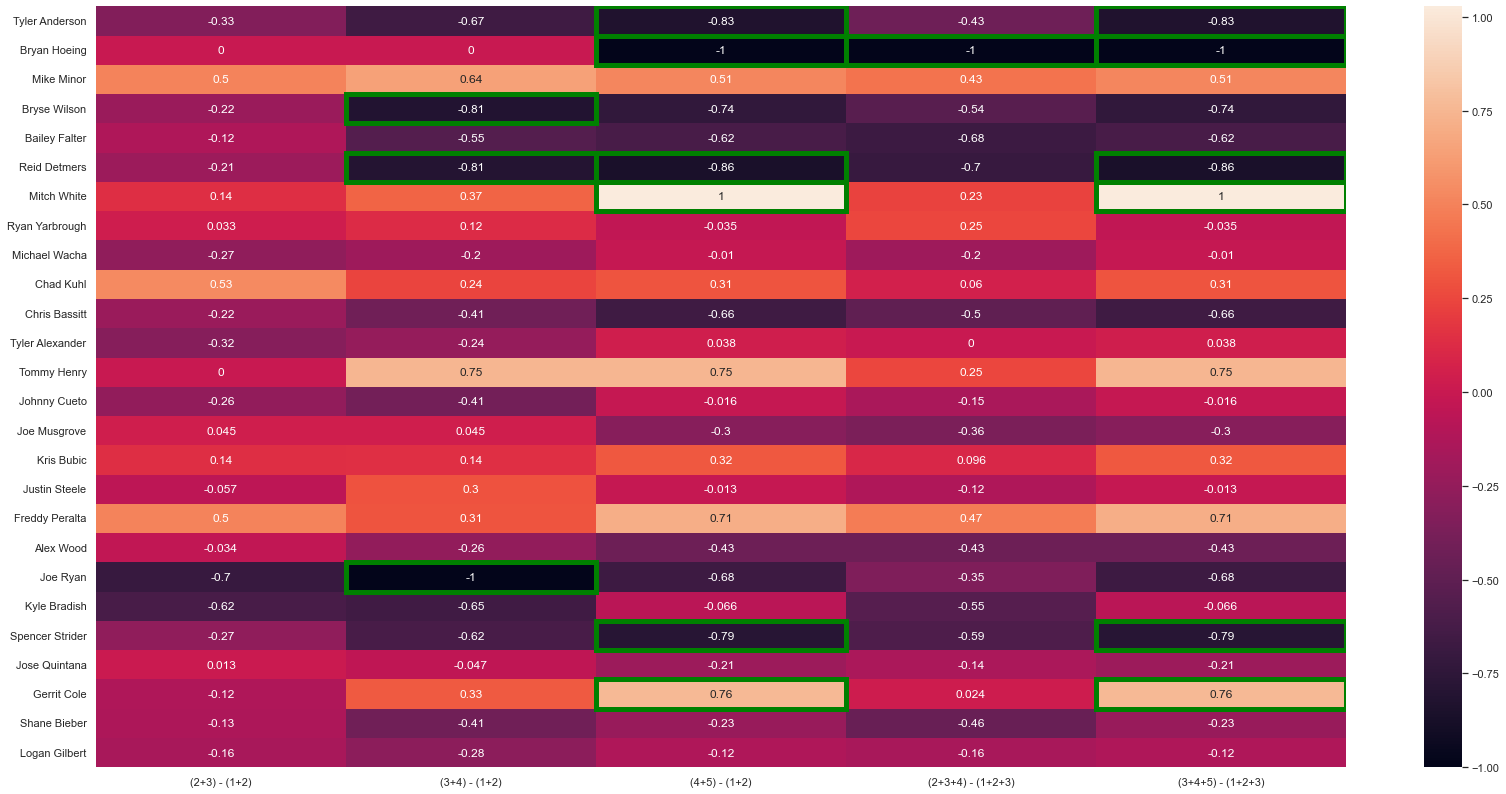

In [4]:
# run for data

split_headers = {
        0:'Platoon Splits',
        1:'Monthly Splits',
        2:'Base Runner Splits',
        3:'Game Type Splits',
        4:'Out Splits',
        5:'Inning Splits',
    } 

starters = get_starting_pitchers()

_ = gather_starter_data(starters, split_headers=split_headers)

_ = generate_inning_lines_a()

t1   = [[i,i+1] for i in range(1,5)]
t2   = [[i,i+1,i+2] for i in range(1,4)]
tups = [[1]] + t1 + t2

tables  = {str(tup):None for tup in tups}

for tup in tups:
    tables[str(tup)] = generate_inning_lines_b(tup, display_df = False)

df = pd.DataFrame()
for k, v in tables.items():
    
    col = v.loc[:, v.columns[0]]
    df[v.columns[0]] = col

# calculate differences between opening lines
# 2 innings.

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

diff_df = inning_diffs(df)

sns.set(rc = {'figure.figsize': (28,14)})
ax   = sns.heatmap(diff_df, annot=True)
val  = 0.75
# find idxs where condition is true
idxs = np.argwhere(abs(diff_df.values) > val)
for idx in idxs:
    ax.add_patch(Rectangle((idx[1], idx[0]), 1, 1, edgecolor='green', fill=False, lw=5))

In [ ]:
columns = [i for i in range(1,6)]
keys    = ['anderson']